<a href="https://colab.research.google.com/github/Frutta111/Deep-Learning-In-PyTorch/blob/main/2_Generate_samples_from_a_discrete_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Generate samples from a discrete distribution**


5/4/2024

In this notebook, we will demonstrate how to create a tensor constructor that samples random numbers from a discrete distribution, which it receives as input.

We will see two different ways of implementation:

1.   Using the direct computation of the Cumulative Distribution Function (CDF)
2.   Using alias method which is a family of efficient algorithms for sampling from a discrete probability distribution. For more details [click here](https://en.wikipedia.org/wiki/Alias_method#Table_generation)


### Method 1 - use the Cumulative Distribution Function (CDF) to sample

To use the Cumulative Distribution Function (CDF) for sampling random numbers from a discrete distribution, follow these steps:

1. Define the Discrete Distribution: Start with a list of probabilities associated with each possible value in the distribution. Ensure that these probabilities sum to 1.

2. Compute the CDF: Construct the CDF by accumulating the probabilities. This means each entry in the CDF will represent the sum of all previous probabilities up to that point.

3. Generate a Uniform Random Number: Generate a random number from a uniform distribution between 0 and 1. This random number will be used to sample from the CDF.

4. Map the Random Number to the Discrete Value: Find the smallest value in the CDF that is greater than or equal to the generated random number. The corresponding value in the original discrete distribution is the sampled value.

5. Repeat for Multiple Samples: Repeat the process for each sample needed to construct the tensor.




In [ ]:
import torch
import matplotlib.pyplot as plt

#### The function

The function `my_sampler(size,dist,requires_grad=False)` returns a tensor of size  `size`, containing numbers sampled from the `dist` distribution, where dist[i] is the probability of sampling the number i.

The arguments:
*   `size`: the size of the output tensor containing the sampled values
*   `dist`: the probabilities of each category
*   `requires_grad`: a boolean indicating whether gradients should be computed for the sampled tensor

Guidelines:
1.   The input vector `dist` must hold:  contains probabilities that sum-up to one, and every term in the vector is not negative.
2.  If the `requires_grad` parameter receives a true value, it will be returned as a tensor output which system automatic derivation follows.

The algorithm:
1.   Generate random numbers x from a uniform distribution U(0,1).
2.   Compute the cumulative distribution function (CDF) of the input distribution dist.
3.   Iterate through the CDF to determine which values were sampled based on the random number.
4.   Turns on autograd for the sampled tensor if requires_grad is set to True, allowing gradients to be computed for this tensor.



In [2]:
import torch

def my_sampler(size, dist, requires_grad=False) :

  """
  Samples random numbers from a discrete distribution to create a tensor.

  Args:
      size (int or tuple): The shape of the tensor to be created.
      dist (list or torch.Tensor): The discrete probability distribution from which to sample.
      requires_grad (bool): If autograd should record operations on the returned tensor. Default is False.

  Returns:
      torch.Tensor: A tensor of sampled values from the discrete distribution.
  """

  # convert *size* to a tuple only if it contains a number
  if isinstance(size, int):
    size = (size,)

  # convert *dist* to a tensor
  if not isinstance(dist, torch.Tensor):
    dist = torch.tensor(dist)

  # Check if the input distribution is a valid probability distribution
  assert ((dist >= 0).all() and len(dist.shape) == 1 and dist.sum() == 1),'dist must be a vector with positive elements that summarize to 1'

  x = torch.rand(size = size) # Generate random numbers of U(0,1) distribution
  CDF = dist.cumsum(dim=0) # Compute the cumulative density/distribution function of the input distribution

  s = torch.zeros(size)  # Initialize the tensor to store the sampled values

  # Iterate through the CDF to determine the sampled values
  for i in range(dist.numel()-1):
    s[(x >= CDF[i]) & (x < CDF[i+1])] = i + 1

  s.requires_grad_(requires_grad) #turn on autograd to begin recording operations on s

  return s

####Usage Examples

Example 1:

Sampling 10 values from a discrete probability distribution with two outcomes, each having a probability of 0.5.

In [4]:
size = 10
dist = torch.tensor([.5, .5])
my_sampler(size, dist)

tensor([0., 1., 0., 0., 1., 1., 1., 0., 1., 1.])

Example 2:

Sampling 2X8 units from a Multi-Class Discrete Distribution with Gradient Tracking with three outcomes with probability of : 0.1, 0.2, and 0.7.

In [3]:
A = my_sampler((2,8), [0.1, 0.2, 0.7], requires_grad=True)
print(A , A.grad , sep = '\n')

tensor([[1., 2., 2., 2., 0., 2., 2., 2.],
        [1., 2., 2., 2., 0., 2., 2., 1.]], requires_grad=True)
None


Example 3:

Distribution vector is not valid

In [5]:
try:
    A = my_sampler((2, 8), [0.1, 0.2, 0.6], requires_grad=True)
    print(A, A.grad, sep='\n')
except AssertionError as e:
    print(f"AssertionError: {e}")

AssertionError: dist must be a vector with positive elements that summarize to 1


####Histogram of probability

Let's check if the function `my_sampler` that we wrote correctly implements the sampling. We will do this by comparing the distribution of the samples to those obtained from PyTorch's built-in function [`torch.multinomial`](https://pytorch.org/docs/stable/generated/torch.multinomial.html#torch-multinomial).

We will visualize the outcomes by histogram plots for comparison.

The function `plot_histogram` is designed to visualize the distributions and samples obtained from two different methods:`torch.multinomial` and a custom sampler. It provides a convenient way to compare the distributions and helps in assessing the effectiveness and accuracy of the custom sampler compared to the built-in method.

The arguments:
1.   `dist` a vector representing the distribution
2.   `my_multinomial_sample` - tensor containing samples generated from a custom sampler.

Function Description:
1.   Generates samples from the distribution dist using t`orch.multinomial(dist, size, replacement=True)`. where `size` is the number of elements of the input tensor
2.   Plotts side by side using Matplotlib two histograms

In [6]:
import matplotlib.pyplot as plt

# Setting the Y axis
def get_max_freq(multinomial_sample1 , multinomial_sample2 ):
  ''' Find the maximum frequency of a sample '''
  unique_elements1, counts1 = torch.unique(multinomial_sample1, return_counts=True) # Get unique elements and their counts
  unique_elements2, counts2 = torch.unique(multinomial_sample2, return_counts=True) # Get unique elements and their counts
  return  max(counts1.max().item() ,  counts2.max().item())

# Plotting the histograms
def plot_histogram(dist, my_multinomial_sample):

  size = torch.numel(my_multinomial_sample)

  multinomial_sample = torch.multinomial(dist, size, replacement=True)

  maxfreq = get_max_freq(my_multinomial_sample,multinomial_sample) * 1.1

  plt.figure(figsize=(10, 5))  # Plot the histograms side by side

  plt.subplot(1, 2, 1)
  plt.hist(multinomial_sample, bins=len(dist), align='mid', rwidth=0.8, range=(-0.5, len(dist)-0.5))
  plt.xlabel('Index')
  plt.ylabel('Frequency')
  plt.title('Histogram of Multinomial Sample \nTorch.multinomial ')
  plt.xticks(range(len(dist))) #sets the tick positions on the x-axis of the histogram.
  plt.ylim(0, maxfreq)  # Set y-axis limits
  plt.grid(axis='y', alpha=0.75) # adds grid lines along the y-axis with transparency level of  0.75

  plt.subplot(1, 2, 2)
  plt.hist(my_multinomial_sample, bins=len(dist), align='mid', rwidth=0.8, range=(-0.5, len(dist)-0.5))
  plt.xlabel('Index')
  plt.ylabel('Frequency')
  plt.title('Histogram of Multinomial Sample \nMy costum sampler')
  plt.xticks(range(len(dist))) #sets the tick positions on the x-axis of the histogram.
  plt.ylim(0, maxfreq)  # Set y-axis limits
  plt.grid(axis='y', alpha=0.75) # adds grid lines along the y-axis with transparency level of  0.75

  plt.tight_layout()  # Adjust subplots to prevent overlap
  plt.show()

Example:

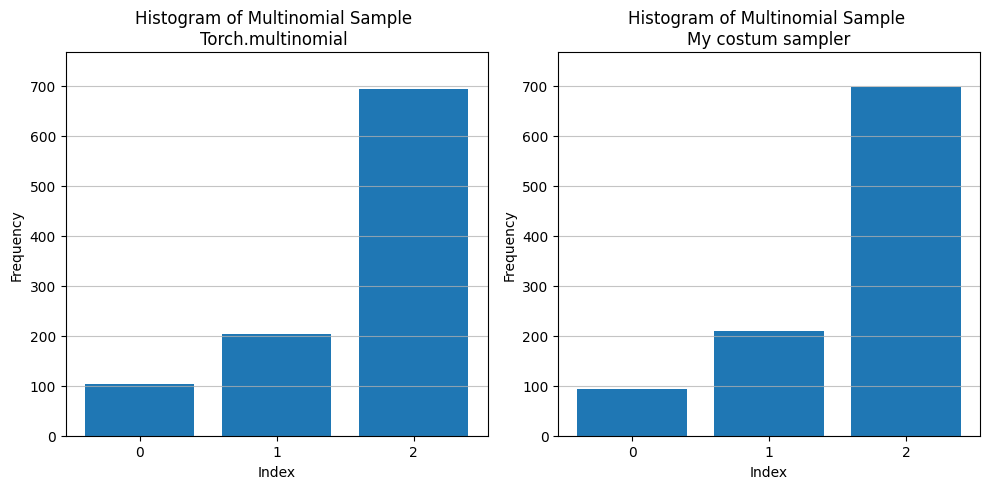

In [9]:
dist = torch.tensor([.1, .2, .7])
size = 1000
my_multinomial_sample = my_sampler(size, dist)
plot_histogram(dist, my_multinomial_sample)


###Method 2 - Use the Alias method to sample


The function `my_alias_sampler(size,dist,requires_grad=False)` returns a tensor of size  `size`, containing numbers sampled from the `dist` distribution, where dist[i] is the probability of sampling the number i.

The arguments:
*   `size`: the size of the output tensor containing the sampled values
*   `dist`: the probabilities of each category
*   `requires_grad`: a boolean indicating whether gradients should be computed for the sampled tensor

Guidelines:
1.   The input vector `dist` must hold:  contains probabilities that sum-up to one, and every term in the vector is not negative.
2.  If the `requires_grad` parameter receives a true value, it will be returned as a tensor output which system automatic derivation follows.

The algorithm: [click here](https://en.wikipedia.org/wiki/Alias_method#Table_generation)

I tried to choose as much as possible the markings and definitions listed in the article. It should be noted that in the article the values ​​of the discrete random variable range between 1 and n, while in the implementation between 0 and (n-1)

In [10]:
import torch
import math

In [11]:
# pad_distribution is an utility function for function "my_alias_sampler"
def pad_distribution(dist):
    '''
    Pad the distribution dist with additional probabilities
    pi = 0 to increase n to a power of two (convenient value)

    Args:
        dist (torch.Tensor or list): The probability distribution to be padded.

    Returns:
        torch.Tensor: The padded probability distribution with length as a power of two.
    '''
    # Calculate the nearest power of 2
    n = math.ceil(math.log2(len(dist)))

    # Calculate the number of additional probabilities needed
    num_to_add = 2**n - len(dist)

    # Create a tensor of additional probabilities with pi = 0
    probs_to_add = torch.zeros(num_to_add)

    # Pad the original distribution with additional probabilities
    padded_dist = torch.cat([dist, probs_to_add])

    return padded_dist

def my_alias_sampler(size, dist, requires_grad=False) :
    '''
    Sample from a discrete probability distribution using the Alias Method.

    Args:
        size (tuple or int): The size of the output tensor.
        dist (torch.Tensor or list): The probability distribution to sample from.
        requires_grad (bool): Whether to enable gradient tracking for the output tensor.

    Returns:
        torch.Tensor: The sampled tensor of the specified size, with optional gradient tracking.
    '''
    # convert *size* to a tuple only if it contains a number
    if isinstance(size, int):
      size = (size,)

    # convert *dist* to a tensor
    if not isinstance(dist, torch.Tensor):
      dist = torch.tensor(dist)

    # Check if the input distribution is a valid probability distribution
    assert ((dist >= 0).all() and len(dist.shape) == 1 and dist.sum() == 1),'dist must be a vector with positive elements that summarize to 1'

    padded_dist = pad_distribution(dist)

    n = padded_dist.numel()

    # Initialize U and K
    U = n * padded_dist
    K = torch.full((n,), float('-inf')) # Create the tensor filled with negative infinity to represet "not initialized"

    #As long as not all table entries are exactly full, repeat the following steps
    # must accomplished in at most n-1 times
    for i in range(padded_dist.numel()-1):
        if ((U == 1.0).all() or (K >= 0).all()):
          break;

        #Arbitrarily choose an overfull entry i
        i = torch.argmax(U).item()

        #Arbitrarily choose an underfull entry j
        mask = K < 0 # Mask where K has not been initialized
        j = torch.argmin(torch.where(mask, U, float('inf'))).item()

        K[j] = i
        U[i] = U[i] - (1-U[j])


    x = torch.rand( size) # Generate random numbers of U(0,1) distribution

    n = padded_dist.numel()
    i = torch.floor(n * x).long()
    y = n * x  - i

    mask = y < U[i]
    s = torch.where(mask, i, K[i])

    s.requires_grad_(requires_grad) #turn on autograd to begin recording operations on s
    return s

####Usage examples

Example 1:

Sampling 10 values from a discrete probability distribution with two outcomes, each having a probability of 0.5.

In [14]:
size = 10
dist = torch.tensor([.5, .5])
my_alias_sampler(size, dist, requires_grad=False)

tensor([1., 1., 1., 0., 0., 1., 1., 1., 0., 1.])

Example 2:

Sampling 2X8 units from a Multi-Class Discrete Distribution with Gradient Tracking with three outcomes with probability of : 0.1, 0.2, and 0.7.

In [15]:
A = my_alias_sampler((2,8), [0.1, 0.2, 0.7], requires_grad=True)
print(A , A.grad , sep = '\n')

tensor([[0., 1., 0., 2., 2., 2., 2., 2.],
        [2., 0., 2., 2., 2., 1., 2., 2.]], requires_grad=True)
None


Example 3:

Distribution vector is not valid

In [13]:
try:
    A = my_alias_sampler((2, 8), [0.1, 0.2, 0.6], requires_grad=True)
    print(A, A.grad, sep='\n')
except AssertionError as e:
    print(f"AssertionError: {e}")



AssertionError: dist must be a vector with positive elements that summarize to 1


####Histogram of probability

Let's check if the function `my_alias_sampler` that we wrote correctly implements the sampling. We will do this by comparing the distribution of the samples to those obtained from PyTorch's built-in function [`torch.multinomial`](https://pytorch.org/docs/stable/generated/torch.multinomial.html#torch-multinomial).

We will visualize the outcomes by histogram plots for comparison.

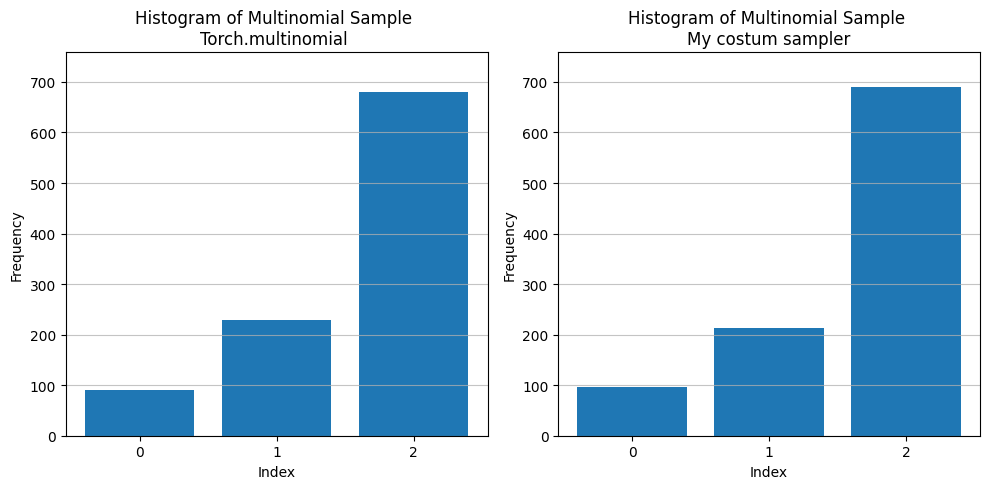

In [12]:
dist = torch.tensor([.1, .2, .7])
size = 1000
my_multinomial_sample = my_alias_sampler(size, dist)
plot_histogram(dist, my_multinomial_sample)